# Astropy including...
* Lomb-Scargle periodogram
* Box least squares (BLS) periodogram

I was hoping to use astropy to get Lomb-Scargle working, and found they also have Box least squares

Following:
http://docs.astropy.org/en/stable/timeseries/index.html#periodogram-algorithms

### examples from astropy site are first,
### PLAsTiCC at the bottom of this notebook

In [4]:
# other references include:
# https://arxiv.org/pdf/1703.09824.pdf
# https://github.com/jakevdp/PracticalLombScargle/
# https://jakevdp.github.io/blog/2017/03/30/practical-lomb-scargle/

In [5]:
from astropy.utils.data import get_pkg_data_filename
filename = get_pkg_data_filename('timeseries/kplr010666592-2009131110544_slc.fits')  


In [6]:
from astropy.timeseries import TimeSeries
ts = TimeSeries.read(filename, format='kepler.fits')  

In [8]:
print(type(ts))

<class 'astropy.timeseries.sampled.TimeSeries'>


In [10]:
ts[0:2]

time,timecorr,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,d,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
object,float32,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2009-05-02T00:41:40.338,6.630610e-04,5500,1.0270451e+06,1.4041933e+02,3.7480554e+03,2.2283568e+00,1.0346376e+06,2.4780812e+02,0,nan,nan,nan,nan,1041.56040,1.3623475e-04,613.47997,1.7336856e-04,1.5822421e-03,-1.4463664e-03
2009-05-02T00:42:39.188,6.630857e-04,5501,1.0271844e+06,1.4042902e+02,3.7491572e+03,2.2283657e+00,1.0347789e+06,2.4594159e+02,0,nan,nan,nan,nan,1041.55834,1.3624557e-04,613.48164,1.7334183e-04,1.5743829e-03,-1.4540013e-03


Text(0, 0.5, 'SAP Flux (e-/s)')

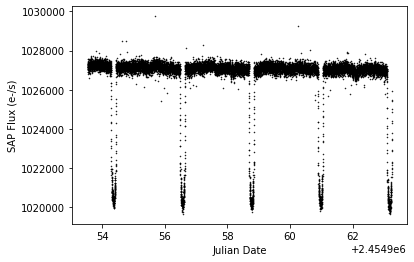

In [12]:
import matplotlib.pyplot as plt
plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')

It looks like there are a few transits! Let’s use the BoxLeastSquares class to estimate the period, using the ‘box least squares’ (BLS) algorithm:

In [15]:
import numpy as np
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
periodogram = BoxLeastSquares.from_timeseries(ts, 'sap_flux')  

In [16]:
results = periodogram.autopower(0.2 * u.day)  
best = np.argmax(results.power)  
period = results.period[best]  
period  

<Quantity 2.20551724 d>

In [17]:
transit_time = results.transit_time[best]  
transit_time  

<Time object: scale='tdb' format='isot' value=2009-05-02T20:51:16.338>

now looking at

http://docs.astropy.org/en/stable/timeseries/bls.html#basic-usage
    

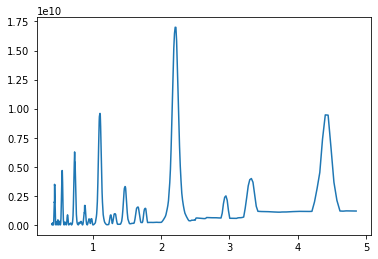

In [18]:
import matplotlib.pyplot as plt                  
plt.plot(results.period, results.power)  

# now try Box least squares on plasticc data...
we will look at only one frequency band

In [22]:
import pandas as pd
import numpy as np
import gc
import os

In [23]:
shared_data_path = r'C:\\Users\\Chris\\Documents\\code_kaggle_plasticc___shared_data\\PLAsTiCC-2018'

In [24]:
# read training data
col_dict = {'mjd': np.float64, 'flux': np.float32, 'flux_err': np.float32, 'object_id': np.int32, 'passband': np.int8,
            'detected': np.int8}
train_meta = pd.read_csv(os.path.join(shared_data_path, 'training_set_metadata.csv'))
train = pd.read_csv(os.path.join(shared_data_path, 'training_set.csv'), dtype=col_dict)

In [25]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

### what are the target classes?

In [28]:
train_meta["target"].unique()

array([92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52,  6, 64, 53],
      dtype=int64)

### how many instances of each class

In [48]:
print(train_meta[train_meta["target"]==92].shape)
print(train_meta[train_meta["target"]==88].shape)
print(train_meta[train_meta["target"]==42].shape)
print(train_meta[train_meta["target"]==90].shape)
print(train_meta[train_meta["target"]==65].shape)
print(train_meta[train_meta["target"]==16].shape)
print(train_meta[train_meta["target"]==67].shape)
print(train_meta[train_meta["target"]==95].shape)
print(train_meta[train_meta["target"]==62].shape)
print(train_meta[train_meta["target"]==15].shape)
print(train_meta[train_meta["target"]==52].shape)
print(train_meta[train_meta["target"]==6].shape)
print(train_meta[train_meta["target"]==64].shape)
print(train_meta[train_meta["target"]==53].shape)

(239, 12)
(370, 12)
(1193, 12)
(2313, 12)
(981, 12)
(924, 12)
(208, 12)
(175, 12)
(484, 12)
(495, 12)
(183, 12)
(151, 12)
(102, 12)
(30, 12)


### binary filter on train_meta using target_id

In [69]:
criterion = train_meta["target"]==92
train_meta_w_class_92 = train_meta[criterion]
train_meta_w_class_92.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0,0.0,0.0,NaN,0.017,92
69,12695,51.855469,-28.630989,224.733260,-55.649872,1,0.0,0.0,0.0,NaN,0.009,92
150,26161,359.415588,-46.768478,327.729895,-67.686097,1,0.0,0.0,0.0,NaN,0.009,92
156,26783,150.820312,1.641510,237.994507,42.358984,1,0.0,0.0,0.0,NaN,0.020,92
162,28391,351.953644,-62.132156,318.777388,-52.347124,1,0.0,0.0,0.0,NaN,0.019,92


In [70]:
print(type(train_meta_w_class_92))

<class 'pandas.core.frame.DataFrame'>


In [72]:
train_meta_w_class_92['object_id'].head()

0        615
69     12695
150    26161
156    26783
162    28391
Name: object_id, dtype: int64

### binary filter on train using object_id

In [73]:
criterion = train["object_id"]==615
train_w_object_id_615 = train[criterion]
train_w_object_id_615.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [85]:
criterion1 = train["object_id"]==615
criterion2 = train["passband"]==2
train_w_object_id_615_pd_2 = train[criterion1 & criterion2]
train_w_object_id_615_pd_2.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
4,615,59752.4070,2,-681.858887,4.041204,1
9,615,59767.2968,2,-548.013550,3.462291,1
14,615,59770.2179,2,-554.903198,3.927843,1
19,615,59779.3188,2,-630.523682,4.333287,1


Text(0, 0.5, 'SAP Flux (e-/s)')

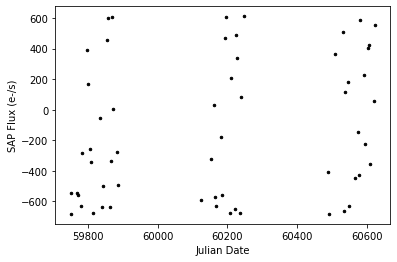

In [87]:
import matplotlib.pyplot as plt
#plt.plot(ts.time.jd, ts['sap_flux'], 'k.', markersize=1)
plt.plot(train_w_object_id_615_pd_2['mjd'], train_w_object_id_615_pd_2['flux'], 'k.', markersize=5)
plt.xlabel('Julian Date')
plt.ylabel('SAP Flux (e-/s)')


In [92]:
import numpy as np
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
periodogram = BoxLeastSquares.from_timeseries(train_w_object_id_615_pd_2, 'flux')  

TypeError: Input time series should be an instance of TimeSeries or BinnedTimeSeries

In [89]:
results = periodogram.autopower(0.2 * u.day)  
best = np.argmax(results.power)  
period = results.period[best]  
period  

<Quantity 2.20551724 d>

In [90]:
transit_time = results.transit_time[best]  
transit_time  

<Time object: scale='tdb' format='isot' value=2009-05-02T20:51:16.338>

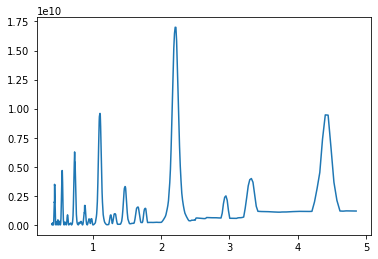

In [91]:
import matplotlib.pyplot as plt                  
plt.plot(results.period, results.power)  